In [1]:
import xarray as xr
import numpy as np

In [2]:
tp_quantile = 0.0013141632
ws10_quantile = 11.48831558227539

In [3]:
speeds = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file


In [4]:
y1 = speeds.ws10.loc['1992-08-24 12:00:00']

test = rainfall.droplevel(level=[0,1])
vals = test.set_index([test.valid_time, test.index])
vals = vals.rename_axis(index={"valid_time":"time"})

y2 = vals.tp.loc['1992-08-24 12:00:00']

y3 = extra.sp.loc['1992-08-24 12:00:00']

In [5]:
mask_ws10 = y1 > ws10_quantile
mask_tp = y2 > tp_quantile

combined_mask = mask_ws10 | mask_tp

# Ensure combined_mask has a MultiIndex (lon, lat)
temp = combined_mask.unstack()
lat = temp.index.values
lon = temp.columns.values

# Loop over lat and lon and apply your conditions
for i in range(len(lat)):
    for j in range(len(lon)):

        # Set to False if outside the specified bounds
        if lat[i] <= 23 or lat[i] >= 29 or lon[j] <= -85 or lon[j] >= -75:

            combined_mask.loc[(lat[i], lon[j])] = False

        # Set to True if within the specified bounds (25 <= lon <= 27, 79 <= lat <= 83)
        if 25 <= lat[i] <= 27 and -82 <= lon[j] <= -79:

            combined_mask.loc[(lat[i], lon[j])] = True

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

Empirical Correlation Plot

In [7]:
import pandas as pd

In [8]:
df_combined = pd.merge(speeds.ws10, vals.tp, on = ['time','latitude','longitude'], how='inner')

df_combined

ws10            tp
time                latitude longitude                        
1992-08-16 00:00:00 32.0     -95.00     2.962953  0.000000e+00
                             -94.75     3.031507  0.000000e+00
                             -94.50     2.941043  0.000000e+00
                             -94.25     2.921770  0.000000e+00
                             -94.00     2.961351  0.000000e+00
...                                          ...           ...
1992-08-28 23:00:00 22.0     -71.00     7.200126  0.000000e+00
                             -70.75     6.961875  0.000000e+00
                             -70.50     6.659889  0.000000e+00
                             -70.25     6.447994  0.000000e+00
                             -70.00     6.381748  4.768372e-07

[1291992 rows x 2 columns]

In [9]:
#Take a time window of 6 hours around our chosen time

window = ['1992-08-24 09:00:00','1992-08-24 10:00:00','1992-08-24 11:00:00','1992-08-24 12:00:00','1992-08-24 13:00:00','1992-08-24 14:00:00','1992-08-24 15:00:00']

df_window = df_combined.loc[window]

In [10]:
correlations = df_window.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
correlations

latitude  longitude
22.0      -95.00      -0.106305
          -94.75       0.021674
          -94.50       0.207343
          -94.25       0.115706
          -94.00       0.030617
                         ...   
32.0      -71.00      -0.774443
          -70.75      -0.522146
          -70.50       0.016641
          -70.25       0.344018
          -70.00       0.553896
Length: 4141, dtype: float64

In [12]:
correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

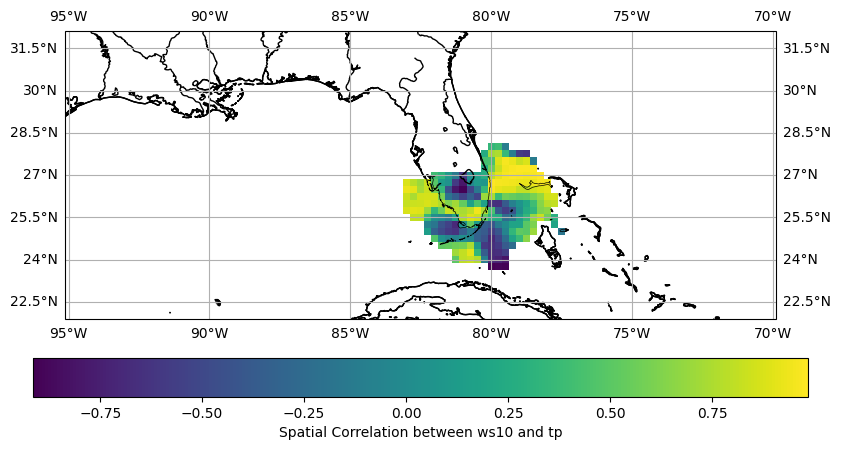

In [13]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [14]:
#12 hour window

window = ['1992-08-24 07:00:00','1992-08-24 08:00:00','1992-08-24 09:00:00','1992-08-24 10:00:00','1992-08-24 11:00:00','1992-08-24 12:00:00','1992-08-24 13:00:00','1992-08-24 14:00:00','1992-08-24 15:00:00','1992-08-24 16:00:00','1992-08-24 17:00:00']

df_window = df_combined.loc[window]

In [23]:
correlations = df_window.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


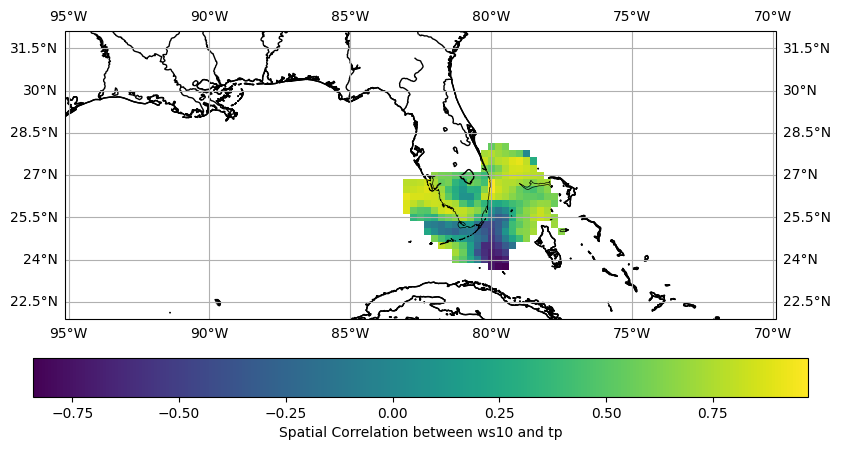

In [16]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

Correlations from 2 variable ICAR model

In [17]:
correlations_icar = pd.read_csv("post_icar_data/two_variable/correlations.csv")

In [18]:
N = sum(combined_mask)
M = len(correlations_icar) - N

In [19]:
node_correlations = correlations_icar[M:].values

In [42]:
data_grid_icar = data_grid.copy()

In [43]:
k = 0

for i in range(101):

    for j in range(41):

        if not np.isnan(data_grid_icar[j,i]):

            data_grid_icar[j,i] = node_correlations[k]

            k+=1

C:\Users\mujta\AppData\Local\Temp\ipykernel_18188\225679069.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_grid_icar[j,i] = node_correlations[k]


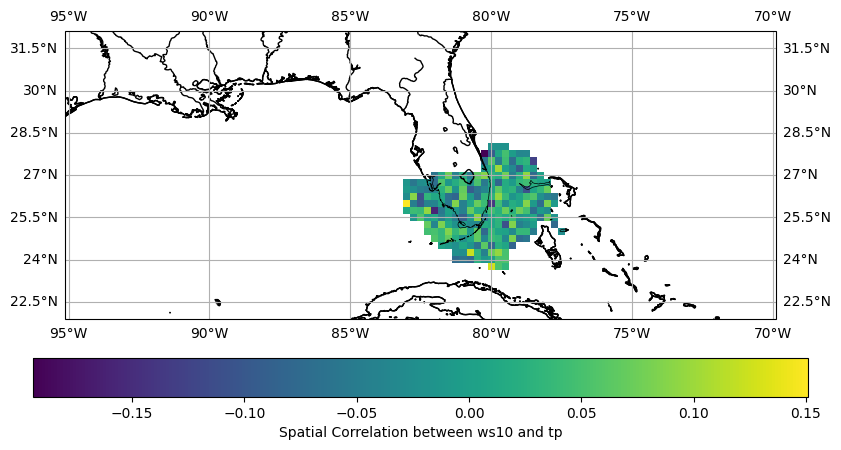

In [47]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid_icar, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [48]:
edge_correlations = correlations_icar[0:M]

In [49]:
node1 = pd.read_csv("pre_icar_data/node1.csv")
node2 = pd.read_csv("pre_icar_data/node2.csv")

In [68]:
full_correlations = node_correlations.copy()

In [69]:
for i in range(len(node1)):
    
    edge = node1.values[i]

    full_correlations[edge] += edge_correlations.values[i]

In [70]:
for i in range(len(node2)):
    
    edge = node2.values[i]

    full_correlations[edge] += edge_correlations.values[i]

In [72]:
data_grid_icar = data_grid.copy()

k = 0

for i in range(101):

    for j in range(41):

        if not np.isnan(data_grid_icar[j,i]):

            data_grid_icar[j,i] = full_correlations[k]

            k+=1

C:\Users\mujta\AppData\Local\Temp\ipykernel_18188\3960707922.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_grid_icar[j,i] = full_correlations[k]


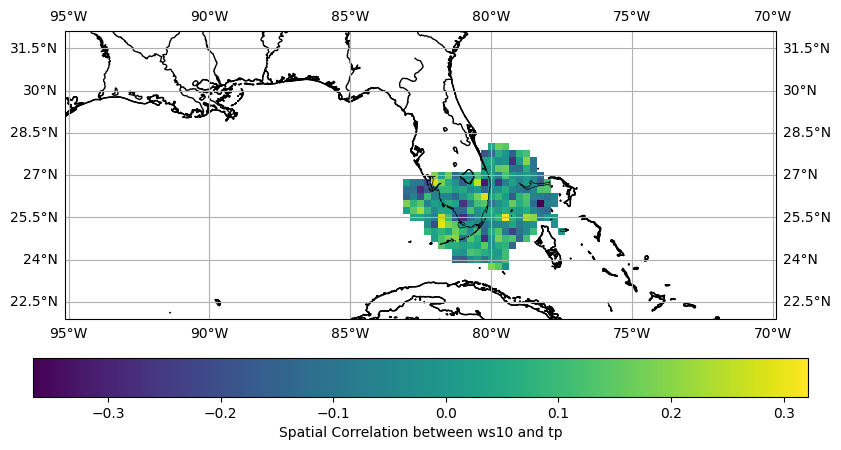

In [73]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid_icar, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);